# Overview

In this notebook, we aim to reproduce the model from [_Zimonyan & Zisserman 2015_](https://arxiv.org/pdf/1409.1556v6.pdf). In other words, we will design an analogous model on TensorFlow, train it with the data from the [ImageNet Object Classification Challenge](https://www.kaggle.com/competitions/imagenet-object-localization-challenge) and ultimately benchmark its performance with the original model. Further information and analytical scripts are available in the [related repository](https://github.com/irenebernardi/VGG-16-replication) for the current project.

In [44]:
# Import packages
import numpy as np
import pandas as pd

from tensorflow import keras
from keras import layers

import os
import shutil

Here we list the constants that will be used for preprocessing and model design.

In [45]:
# Define constants

# Set number of classes to use (this is a way to subset the data)
CLASS_NUM = 3
# Set batch size for mini-batch gradient descent
BATCH_SIZE = 32
#BATCH_SIZE = 256

# Set kernel size for Conv2D layers
KERNEL_SIZE = 3
# Set padding mode for Conv2D layers
PAD_MODE = "same"
# Set activation function for Conv2D layers
ACTIVATION = "relu"

# Set pool size for MaxPool2D layers
POOL_SIZE = 2
# Set strides for MaxPool2D layers
POOL_STRIDES=2

# Data Preprocessing

Because the train set is big (`train_dir`), we take a subset of classes defined by `CLASS_NUM` and copy the images belonging to that subset of classes to our working directory (`subset_dir`). Initially, we will train the model using only this subset.

In [46]:
# Store paths to base, train set and subset dirs
base_dir = "/kaggle/input/imagenet-object-localization-challenge"
train_dir = base_dir + "/ILSVRC/Data/CLS-LOC/train"
subset_dir = "/kaggle/working/data"

if not os.path.exists(subset_dir):
    os.mkdir(subset_dir)
    print(subset_dir, "created!")
else:
    print(subset_dir, "already exists!")
    
# Select only first n class dirs
class_dirs = os.listdir(train_dir)[:CLASS_NUM]

# Copy class dir from train set to working dir
for class_dir in class_dirs:
    # Define current source and destination paths
    source_dir = train_dir + "/" + class_dir
    destination_dir = subset_dir + "/" + class_dir
    
    # If new class, copy to working dir
    if not os.path.exists(destination_dir):
        shutil.copytree(source_dir, destination_dir)
        print(class_dir, "succesfully copied!")
    # If it exists, don't copy again
    else:
        print(class_dir, "doesn't need copying!")

/kaggle/working/data already exists!
n01531178 doesn't need copying!
n02412080 doesn't need copying!
n02098413 doesn't need copying!


Now that the images were copied in our working directory, we try to open one as a sanity check. Which animal did you find?

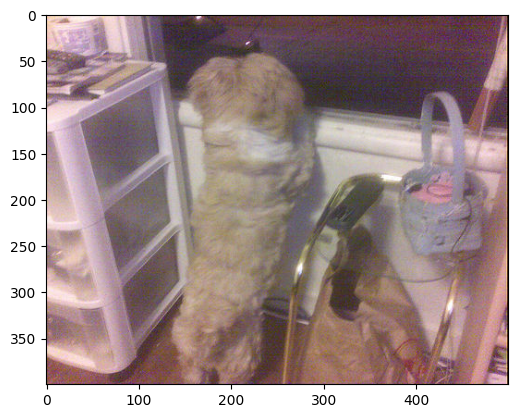

In [47]:
from matplotlib import pyplot as plt
from matplotlib import image

# Read in image
image = image.imread(subset_dir + "/n02098413/n02098413_720.JPEG")
# Show image
plt.imshow(image)

Then, we import our train set with keras utils. We are now ready to use it to train a model!

In [48]:
# Import train set as a Dataset object
# (this object type can be used as input to the model)
raw_train_set = keras.utils.image_dataset_from_directory(
    subset_dir,
    image_size=(224, 224),
    batch_size=BATCH_SIZE
)

Found 3900 files belonging to 3 classes.


# Model Design

In [49]:
# Normalise images to [0-1] scale
train_set = raw_train_set.map(lambda x, y: (x / 255, y))
# Separate images and labels
images, labels = next(iter(train_set))

# Prepare data for training
X_train = images
y_train = pd.get_dummies(labels)

# Check input shape
input_shape = X_train.shape[1:]
print(f"Input shape: {input_shape}")

Input shape: (224, 224, 3)


I am trying to use a function to reduce redundancy in the model design. However, the layers are not aware of the input shape when they are created outside of `keras.Sequential`. I am still trying to figure out how to overcome this problem.

In [50]:
def generate_layer(filters, kernel_size = 3, padding="same", activation="relu", **kwargs):

    conv_layer = layers.Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        padding=padding,
        activation=activation,
        **kwargs
    )
    
    return conv_layer

conv_layer64 = generate_layer(filters=64, input_shape=input_shape)
conv_layer128 = generate_layer(filters=128)
conv_layer256 = generate_layer(filters=256)
conv_layer512 = generate_layer(filters=512)
pooling_layer = layers.MaxPool2D(pool_size=2, strides=2)
dense_layer4096 = layers.Dense(4096, activation="relu", input_shape=[4096])

# Design model
# model = keras.models.Sequential([
#     conv_layer64, pooling_layer,
#     conv_layer128, pooling_layer,
#     conv_layer256, conv_layer256, pooling_layer,
#     conv_layer512, conv_layer512, pooling_layer,
#     conv_layer512, conv_layer512, pooling_layer,
#     layers.Flatten(),
#     dense_layer4096, dense_layer4096,
#     layers.Dense(CLASS_NUM, activation="softmax")
# ])

In general, the model architecture resembles the model from the paper pretty well, even though some details may still be missing.

In [51]:
# Design model
model = keras.models.Sequential([
    
    # 1st convolutional block
    layers.Conv2D(input_shape=input_shape, filters=64, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
    layers.MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # 2nd convolutional block
    layers.Conv2D(filters=128, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
    layers.MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # 3rd convolutional block
    layers.Conv2D(filters=256, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
    layers.Conv2D(filters=256, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
    layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # 4th convolutional block
    layers.Conv2D(filters=512, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
    layers.Conv2D(filters=512, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
    layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # 5th convolutional block
    layers.Conv2D(filters=512, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
    layers.Conv2D(filters=512, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
    layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # Classifier head
    layers.Flatten(),
    layers.Dense(4096, activation=ACTIVATION),
    layers.Dropout(rate=0.5),
    layers.Dense(4096, activation=ACTIVATION),
    layers.Dropout(rate=0.5),
    layers.Dense(CLASS_NUM, activation="softmax")
])

# Choose optimiser, loss function and validation metric
model.compile(
    optimizer=keras.optimizers.experimental.SGD(momentum=0.9, weight_decay=0.0005),
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"]
)

To test that the model works, we train it for a few epochs. Ideally, we will train the model on the full dataset when once it resembles the model from the paper in terms of parameter number. 

In [55]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=BATCH_SIZE,
    verbose=True
)

# Store training history as a dataframe
history_df = pd.DataFrame(history.history)

print(f"Train loss: {history_df['loss'].iloc[-1]:.3f}")
print(f"Train accuracy: {history_df['categorical_accuracy'].iloc[-1]:.3f}")

Epoch 1/5
1/1 [==============================] - 11s 11s/step - loss: 1.0930 - categorical_accuracy: 0.4688
Epoch 2/5
1/1 [==============================] - 11s 11s/step - loss: 1.0899 - categorical_accuracy: 0.4688
Epoch 3/5
1/1 [==============================] - 11s 11s/step - loss: 1.0845 - categorical_accuracy: 0.4688
Epoch 4/5
1/1 [==============================] - 11s 11s/step - loss: 1.0806 - categorical_accuracy: 0.4688
Epoch 5/5
1/1 [==============================] - 11s 11s/step - loss: 1.0722 - categorical_accuracy: 0.4688
Train loss: 1.072
Train accuracy: 0.469


The model contains 128778627 trainable parameters, which aligns pretty well with the 33 million in the paper. Our model may still lack some element responsible for the missing 4 million parameters.

<Axes: title={'center': 'Loss'}>

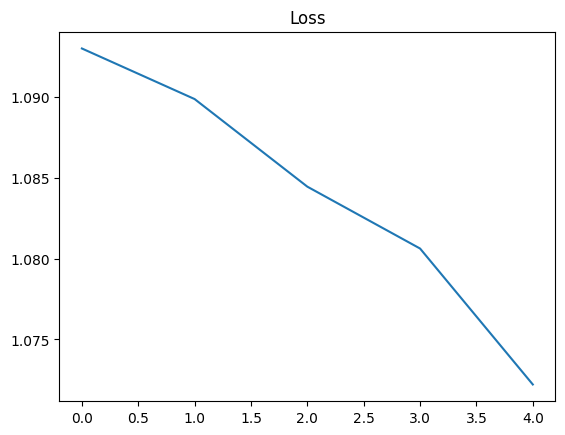

In [56]:
# Visualise loss
history_df.loc[:, "loss"].plot(title="Loss")

<Axes: title={'center': 'Accuracy'}>

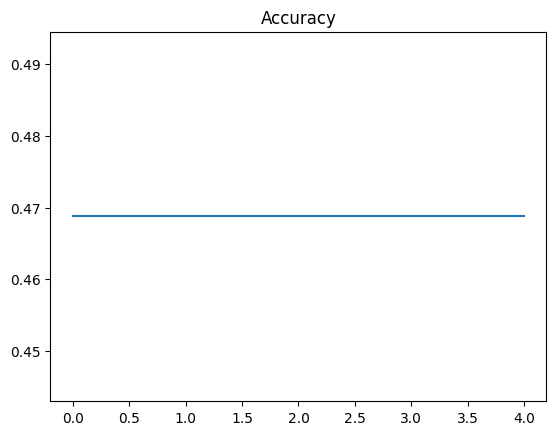

In [57]:
# Visualise accuracy
history_df.loc[:, "categorical_accuracy"].plot(title="Accuracy")

# Transfer Learning

The next step involves building a deeper ConvNet by:
1. taking the pretrained base from the previous section,
2. enriching it with new untrained convolutional layers and
3. attaching it to a new untrained classification head

By transferring the learnt weight from our previous model, we can build more complex and deeper ConvNets without too much computational burden. In particular, here we aim to reproduce the following four architectures from _Zimonyan & Zisserman 2015_:
- 13-layer ConvNet
- 16-layer ConvNet (with 1-by-1 filters)
- 16-layer ConvNet (with 3-by-3 filters)
- 19-layer ConvNet

In the following cell, we pretend that the previously trained model is stored in a keras file to show how pretrained models can be imported into a notebook.

In [59]:
# Define model file
model_file = f"/kaggle/working/{CLASS_NUM}class_model.keras"

# Save model into file for replication purposes
model.save(model_file)

# Import pretrained base
new_model = keras.models.load_model(model_file)

# IMPORTANT: Set weights from base as untrainable
new_model.trainable = False

Because we want to add new convolutional layers between the pretrained ones, we have to separate the latter from the whole pretrained base as done below.

In [60]:
# List indices of relevant layers (only convolutional, no maxpool)
layer_positions = [0, 2, 4, 5, 7, 8, 10, 11]

# Select relevant layers
pretrained_layers = [new_model.get_layer(index=i) for i in layer_positions]

## 13-layer ConvNet

Here, we build and train a 13-layer ConvNet with a half pretrained half untrained base.

In [61]:
# Design model
model = keras.models.Sequential([
    
    # 1st convolutional block
    pretrained_layers[0],
    layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
    layers.MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # 2nd convolutional block
    pretrained_layers[1],
    layers.Conv2D(filters=128, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
    layers.MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # 3rd convolutional block
    pretrained_layers[2],
    pretrained_layers[3],
    layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # 4th convolutional block
    pretrained_layers[4],
    pretrained_layers[5],
    layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # 5th convolutional block
    pretrained_layers[6],
    pretrained_layers[7],
    layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),
    
    # Classifier head
    layers.Flatten(),
    layers.Dense(4096, activation=ACTIVATION),
    layers.Dropout(rate=0.5),
    layers.Dense(4096, activation=ACTIVATION),
    layers.Dropout(rate=0.5),
    layers.Dense(CLASS_NUM, activation="softmax")
])

# Choose optimiser, loss function and validation metric
model.compile(
    optimizer=keras.optimizers.experimental.SGD(momentum=0.9, weight_decay=0.0005),
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"]
)

In [62]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=BATCH_SIZE,
    verbose=True
)

# Store training history as a dataframe
history_df = pd.DataFrame(history.history)

print(f"Train loss: {history_df['loss'].iloc[-1]:.3f}")
print(f"Train accuracy: {history_df['categorical_accuracy'].iloc[-1]:.3f}")

Epoch 1/5
1/1 [==============================] - 15s 15s/step - loss: 1.1000 - categorical_accuracy: 0.1875
Epoch 2/5
1/1 [==============================] - 13s 13s/step - loss: 1.0970 - categorical_accuracy: 0.4375
Epoch 3/5
1/1 [==============================] - 13s 13s/step - loss: 1.0967 - categorical_accuracy: 0.4062
Epoch 4/5
1/1 [==============================] - 13s 13s/step - loss: 1.0947 - categorical_accuracy: 0.4375
Epoch 5/5
1/1 [==============================] - 13s 13s/step - loss: 1.0912 - categorical_accuracy: 0.4688
Train loss: 1.091
Train accuracy: 0.469


<Axes: title={'center': 'Loss'}>

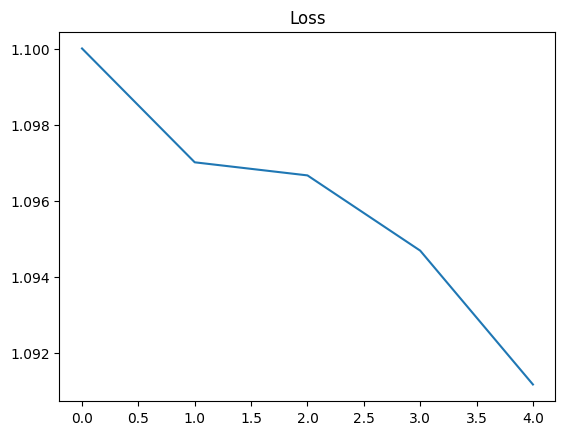

In [64]:
# Visualise loss
history_df.loc[:, "loss"].plot(title="Loss")

<Axes: title={'center': 'Accuracy'}>

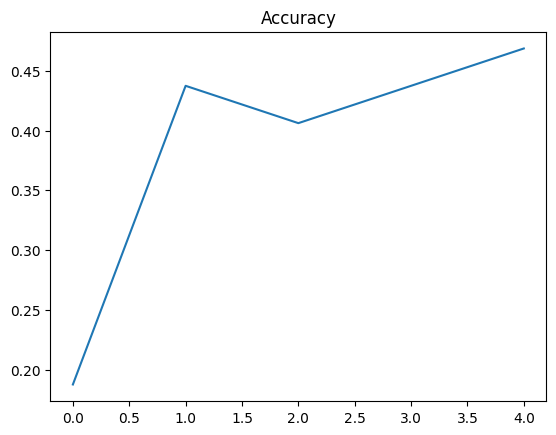

In [65]:
# Visualise accuracy
history_df.loc[:, "categorical_accuracy"].plot(title="Accuracy")